<a href="https://colab.research.google.com/github/MahdiTheGreat/Financial-Instrument-sentiment-Analysis/blob/main/Auto_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima backtrader pipdeptree
!pip uninstall numpy -y
!pip install numpy==1.26.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.2 MB/s eta 0:00:00


In [21]:
# Import libraries
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import os
import warnings

tickers=["SPY","XIC","ISF","C40","1321.T","2833.HK","IOZ"]

def get_stock_price_data(ticker,end_date=None,days=365,period=None, interval="1d"):
  # Fetch historical data
    stock = yf.Ticker(ticker)
    if not end_date:
     end_date = datetime.today()
    if days:
      start_date = end_date - timedelta(days=days)
      data = stock.history(start=start_date, end=end_date,interval=interval)
    elif period:
      data = stock.history(period=period, interval=interval)
    else:
      data = stock.history(interval=interval,period="max")
    return data


# 📌 Step 1: Download Stock Data
ticker = tickers[0] # Change this to any stock symbol
end_date="2025-03-17"
end_date = datetime.strptime(end_date, '%Y-%m-%d')
forecast_steps=21
lookback_days=365
df = get_stock_price_data(ticker=ticker,days=lookback_days+forecast_steps,end_date=end_date)
#stock_data=get_stock_price_data(ticker=ticker,period="max",days=None)
df.name=ticker
print(len(df))
df.head()

264


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-02-26 00:00:00-05:00,501.862437,502.306750,499.453337,499.581696,50386700,0.0,0.0,0.0
2024-02-27 00:00:00-05:00,500.282759,500.736925,498.357443,500.509827,48854500,0.0,0.0,0.0
2024-02-28 00:00:00-05:00,498.930083,500.440705,498.564774,499.848328,56506600,0.0,0.0,0.0
2024-02-29 00:00:00-05:00,501.635380,503.284213,498.949827,501.645233,83924800,0.0,0.0,0.0
2024-03-01 00:00:00-05:00,502.533876,506.789258,502.119182,506.354828,76805900,0.0,0.0,0.0


In [18]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape


# Function to fit the ARIMA model
def fit_arima_model(df):
    warnings.filterwarnings("ignore")
    kpss_diffs = ndiffs(df, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)

    print(f"Estimated differencing term: {n_diffs}")


    auto_model=auto_arima(df, d=n_diffs, seasonal=False, stepwise=True,
                      suppress_warnings=True, error_action="ignore",information_criterion='bic',
                      max_order=None, trace=True)

    # Get the best ARIMA order
    p, d, q = auto_model.order  # d is already determined above
    print(f"Best ARIMA Order: p={p}, d={d}, q={q}")
    return auto_model


def arima_forecast(df, forecast_steps):

 model=fit_arima_model(df)
 fc, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
 return (
     fc.tolist(),
     np.asarray(conf_int).tolist())


# Function to test ARIMA forecasts
def test_forecast(df, forecast_func, forecast_steps=21):
    warnings.filterwarnings("ignore")

    train_len = df.shape[0] - forecast_steps
    train_data, test_data = df[:train_len], df[train_len:]

    y_train = train_data
    y_test = test_data

    print(f"{train_len} train samples")
    print(f"{df.shape[0] - train_len} test samples")

    # Generate forecasts and confidence intervals
    fc, conf = forecast_func(df=y_train, forecast_steps=forecast_steps)

    print("Forecasted values:\n", fc)
    print("Confidence intervals:\n", conf)

    # Calculate error metrics
    print(f"Mean squared error: {mean_squared_error(y_test, fc)}")
    print(f"SMAPE: {smape(y_test, fc)}")

    # Create a single plot
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(train_data.index, y_train, color='blue', label='Training Data')

    # Plot actual test data
    plt.plot(test_data.index, y_test, color='red', label='Actual Price')

    # Plot forecasted values
    plt.plot(test_data.index, fc, color='green', marker='o', label='Predicted Price')

    # Plot confidence intervals
    conf_int = np.asarray(conf)
    plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3, label="95% Confidence Interval")

    # Add labels, title, and legend
    plt.title(f'{df.name} Prices Prediction with Confidence Intervals')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_weighted_parameters(df):
    """
    Computes weighted average drift (mu) and volatility (sigma) over the entire dataset.
    Expects `df` to be a pandas Series or DataFrame.
    """
    log_returns = np.log(df / df.shift(1)).dropna()
    weights = np.arange(1, len(log_returns) + 1)  # Linear weights, giving more weight to recent data
    weights = weights / weights.sum()  # Normalize weights

    mu = np.sum(weights * log_returns)  # Weighted mean
    sigma = np.sqrt(np.sum(weights * (log_returns - mu) ** 2))  # Weighted std deviation

    return mu, sigma

def gbm_forecast(df, forecast_steps):
    """
    Uses historical data to forecast Y days ahead using GBM with weighted drift and volatility.
    Returns forecasted values and confidence intervals in a format similar to ARIMA.
    """
    N = 1000  # Number of simulation paths
    mu, sigma = compute_weighted_parameters(df)  # Pass the pandas Series/DataFrame directly
    S_hist = df.values
    S0 = S_hist[-1]  # Last known price
    S = np.zeros((forecast_steps, N))
    S[0] = S0

    for i in range(1, forecast_steps):
        dW = np.random.normal(0, 1, N)  # Brownian motion increment
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) + sigma * dW)

    # Compute mean and confidence intervals
    S_mean = np.mean(S, axis=1)
    S_std = np.std(S, axis=1)
    conf_interval = 1.96 * S_std  # 95% confidence interval

    # Prepare confidence intervals in the format expected by the test function
    conf_int = np.column_stack((S_mean - conf_interval, S_mean + conf_interval))
    print("conf_int")
    print(conf_int)

    return S_mean.tolist(), conf_int.tolist()

243 train samples
21 test samples
Estimated differencing term: 1
Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1415.150, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1420.301, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1420.306, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1411.946, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1425.789, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.294 seconds
Best ARIMA Order: p=0, d=1, q=0
Forecasted values:
 [603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.3599853515625, 603.359985

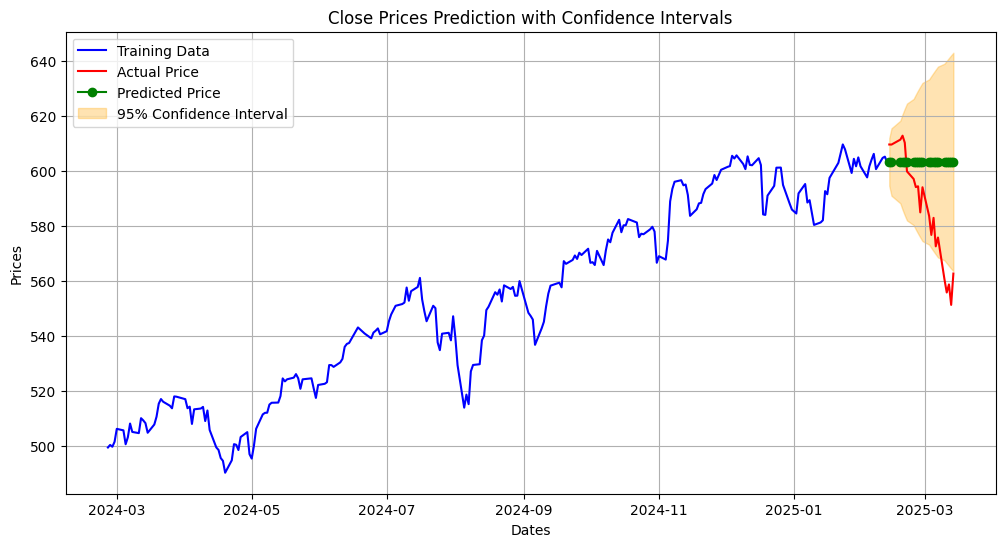

243 train samples
21 test samples


,Close
Date,
2024-02-26 00:00:00-05:00,499.581696
2024-02-27 00:00:00-05:00,500.509827
2024-02-28 00:00:00-05:00,499.848328
2024-02-29 00:00:00-05:00,501.645233
2024-03-01 00:00:00-05:00,506.354828
...,...
2025-02-06 00:00:00-05:00,606.320007
2025-02-07 00:00:00-05:00,600.770020
2025-02-10 00:00:00-05:00,604.849976


Forecasted values:
 [603.3599853515625, 603.7721639394052, 604.4328195590551, 605.0839260741725, 605.5714182468948, 606.1254307338871, 606.7654664060354, 607.1323159361745, 607.3963989387471, 607.4412221127711, 607.8439074066486, 608.3347082916156, 609.2623241017137, 609.5174631266295, 610.1070278640236, 610.4538084754456, 610.8479416085092, 611.2119238594577, 611.6943253296334, 612.1627008821191, 612.7731902837842]
Confidence intervals:
 [[603.3599853515625, 603.3599853515625], [594.2884584583175, 613.255869420493], [590.9243687655554, 617.9412703525549], [588.4019432603488, 621.7659088879961], [586.1928874403018, 624.9499490534879], [584.375374051411, 627.8754874163633], [583.0335037389686, 630.4974290731022], [581.1330088692241, 633.1316230031248], [579.3238886590153, 635.4689092184789], [577.8969814622168, 636.9854627633255], [576.237757515314, 639.4500572979831], [574.9221524071523, 641.7472641760788], [574.6555063046046, 643.8691418988228], [573.0577125649879, 645.9772136882711],

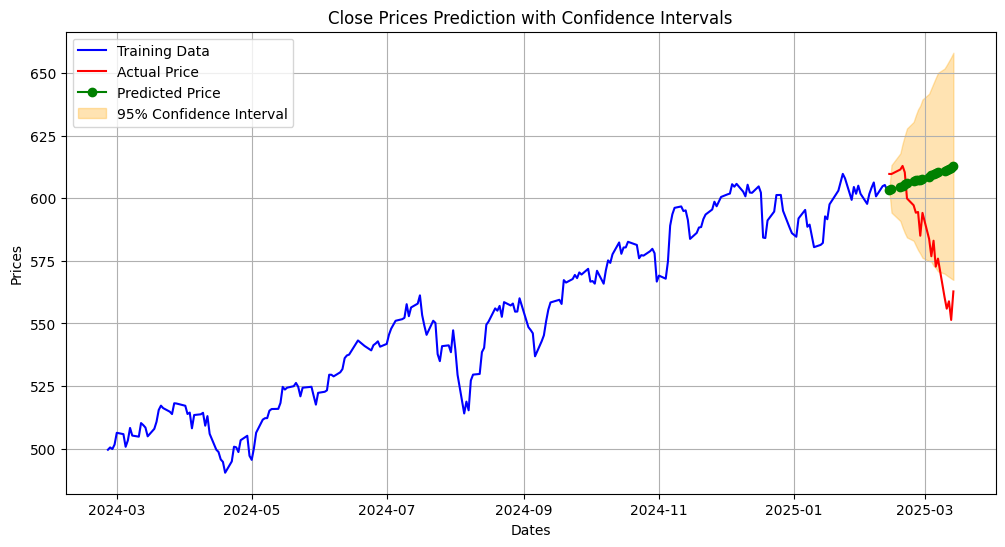

In [22]:
test_forecast(df=df['Close'],forecast_func=arima_forecast)
test_forecast(df=df['Close'], forecast_func=gbm_forecast)

In [26]:
from tqdm import tqdm  # Import tqdm for the progress bar

import pandas as pd


# Function to precompute ARIMA forecasts
def precompute_forecasts(df, forecast_func, lookback_period=252, forecast_steps=21):
    # Initialize lists to store forecasts and confidence intervals
    forecasts = []
    conf_intervals = []

    # Precompute forecasts with a progress bar
    for i in tqdm(range(lookback_period, len(df)), desc="Precomputing Forecasts"):
        # Extract the rolling window data
        window_data = df.iloc[i - lookback_period:i]

        # Forecast the next `forecast_steps` steps
        fc, conf = forecast_func(df=window_data, forecast_steps=forecast_steps)

        # Append results to lists
        forecasts.append(fc)
        conf_intervals.append(conf)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Date': df.index[lookback_period:],
        'Forecast': forecasts,
        'Confidence_Interval_Lower': [x[0][0] for x in conf_intervals],
        'Confidence_Interval_Upper': [x[0][1] for x in conf_intervals],
    })

    # Create a folder named after the forecast function
    forecast_func_name = forecast_func.__name__  # Get the name of the forecast function
    folder_path = os.path.join(os.getcwd(), forecast_func_name)  # Create folder path

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the results to a CSV file inside the folder
    file_path = os.path.join(folder_path, f'{df.name}.csv')
    results.to_csv(file_path, index=False)
    print(f"Forecasts saved to {file_path}")

    return results

precompute_forecasts(df=df['Close'],forecast_func=gbm_forecast)

Precomputing Forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

,Close
Date,
2024-02-26 00:00:00-05:00,499.581696
2024-02-27 00:00:00-05:00,500.509827
2024-02-28 00:00:00-05:00,499.848328
2024-02-29 00:00:00-05:00,501.645233
2024-03-01 00:00:00-05:00,506.354828
...,...
2025-02-20 00:00:00-05:00,610.380005
2025-02-21 00:00:00-05:00,599.940002
2025-02-24 00:00:00-05:00,597.210022


,Close
Date,
2024-02-27 00:00:00-05:00,500.509827
2024-02-28 00:00:00-05:00,499.848328
2024-02-29 00:00:00-05:00,501.645233
2024-03-01 00:00:00-05:00,506.354828
2024-03-04 00:00:00-05:00,505.811798
...,...
2025-02-21 00:00:00-05:00,599.940002
2025-02-24 00:00:00-05:00,597.210022
2025-02-25 00:00:00-05:00,594.239990


,Close
Date,
2024-02-28 00:00:00-05:00,499.848328
2024-02-29 00:00:00-05:00,501.645233
2024-03-01 00:00:00-05:00,506.354828
2024-03-04 00:00:00-05:00,505.811798
2024-03-05 00:00:00-05:00,500.756622
...,...
2025-02-24 00:00:00-05:00,597.210022
2025-02-25 00:00:00-05:00,594.239990
2025-02-26 00:00:00-05:00,594.539978


,Close
Date,
2024-02-29 00:00:00-05:00,501.645233
2024-03-01 00:00:00-05:00,506.354828
2024-03-04 00:00:00-05:00,505.811798
2024-03-05 00:00:00-05:00,500.756622
2024-03-06 00:00:00-05:00,503.294098
...,...
2025-02-25 00:00:00-05:00,594.239990
2025-02-26 00:00:00-05:00,594.539978
2025-02-27 00:00:00-05:00,585.049988


Precomputing Forecasts:  33%|███▎      | 4/12 [00:00<00:00, 36.93it/s]

,Close
Date,
2024-03-01 00:00:00-05:00,506.354828
2024-03-04 00:00:00-05:00,505.811798
2024-03-05 00:00:00-05:00,500.756622
2024-03-06 00:00:00-05:00,503.294098
2024-03-07 00:00:00-05:00,508.289978
...,...
2025-02-26 00:00:00-05:00,594.539978
2025-02-27 00:00:00-05:00,585.049988
2025-02-28 00:00:00-05:00,594.179993


,Close
Date,
2024-03-04 00:00:00-05:00,505.811798
2024-03-05 00:00:00-05:00,500.756622
2024-03-06 00:00:00-05:00,503.294098
2024-03-07 00:00:00-05:00,508.289978
2024-03-08 00:00:00-05:00,505.239136
...,...
2025-02-27 00:00:00-05:00,585.049988
2025-02-28 00:00:00-05:00,594.179993
2025-03-03 00:00:00-05:00,583.770020


,Close
Date,
2024-03-05 00:00:00-05:00,500.756622
2024-03-06 00:00:00-05:00,503.294098
2024-03-07 00:00:00-05:00,508.289978
2024-03-08 00:00:00-05:00,505.239136
2024-03-11 00:00:00-04:00,504.804718
...,...
2025-02-28 00:00:00-05:00,594.179993
2025-03-03 00:00:00-05:00,583.770020
2025-03-04 00:00:00-05:00,576.859985


,Close
Date,
2024-03-06 00:00:00-05:00,503.294098
2024-03-07 00:00:00-05:00,508.289978
2024-03-08 00:00:00-05:00,505.239136
2024-03-11 00:00:00-04:00,504.804718
2024-03-12 00:00:00-04:00,510.235046
...,...
2025-03-03 00:00:00-05:00,583.770020
2025-03-04 00:00:00-05:00,576.859985
2025-03-05 00:00:00-05:00,583.059998


,Close
Date,
2024-03-07 00:00:00-05:00,508.289978
2024-03-08 00:00:00-05:00,505.239136
2024-03-11 00:00:00-04:00,504.804718
2024-03-12 00:00:00-04:00,510.235046
2024-03-13 00:00:00-04:00,509.435333
...,...
2025-03-04 00:00:00-05:00,576.859985
2025-03-05 00:00:00-05:00,583.059998
2025-03-06 00:00:00-05:00,572.710022


,Close
Date,
2024-03-08 00:00:00-05:00,505.239136
2024-03-11 00:00:00-04:00,504.804718
2024-03-12 00:00:00-04:00,510.235046
2024-03-13 00:00:00-04:00,509.435333
2024-03-14 00:00:00-04:00,508.428253
...,...
2025-03-05 00:00:00-05:00,583.059998
2025-03-06 00:00:00-05:00,572.710022
2025-03-07 00:00:00-05:00,575.919983


,Close
Date,
2024-03-11 00:00:00-04:00,504.804718
2024-03-12 00:00:00-04:00,510.235046
2024-03-13 00:00:00-04:00,509.435333
2024-03-14 00:00:00-04:00,508.428253
2024-03-15 00:00:00-04:00,504.937073
...,...
2025-03-06 00:00:00-05:00,572.710022
2025-03-07 00:00:00-05:00,575.919983
2025-03-10 00:00:00-04:00,560.580017


,Close
Date,
2024-03-12 00:00:00-04:00,510.235046
2024-03-13 00:00:00-04:00,509.435333
2024-03-14 00:00:00-04:00,508.428253
2024-03-15 00:00:00-04:00,504.937073
2024-03-18 00:00:00-04:00,507.938019
...,...
2025-03-07 00:00:00-05:00,575.919983
2025-03-10 00:00:00-04:00,560.580017
2025-03-11 00:00:00-04:00,555.919983


Precomputing Forecasts: 100%|██████████| 12/12 [00:00<00:00, 60.00it/s]

Forecasts saved to /content/gbm_forecast/Close.csv


,Date,Forecast,Confidence_Interval_Lower,Confidence_Interval_Upper
0,2025-02-27 00:00:00-05:00,"[594.5399780273438, 594.9505932715198, 595.135...",594.539978,594.539978
1,2025-02-28 00:00:00-05:00,"[585.0499877929688, 585.4435033793746, 585.814...",585.049988,585.049988
2,2025-03-03 00:00:00-05:00,"[594.1799926757812, 594.5394133009386, 594.818...",594.179993,594.179993
3,2025-03-04 00:00:00-05:00,"[583.77001953125, 583.7560616140198, 584.30382...",583.770020,583.770020
4,2025-03-05 00:00:00-05:00,"[576.8599853515625, 576.8057499702342, 576.798...",576.859985,576.859985
5,2025-03-06 00:00:00-05:00,"[583.0599975585938, 583.033511967741, 583.3675...",583.059998,583.059998
6,2025-03-07 00:00:00-05:00,"[572.7100219726562, 573.2112398189834, 573.080...",572.710022,572.710022
7,2025-03-10 00:00:00-04:00,"[575.9199829101562, 576.223701014598, 576.3794...",575.919983,575.919983
8,2025-03-11 00:00:00-04:00,"[560.5800170898438, 560.465365158523, 560.3272...",560.580017,560.580017
9,2025-03-12 00:00:00-04:00,"[555.9199829101562, 555.6765573113295, 555.447...",555.919983,555.919983


In [ ]:
import backtrader as bt
import pandas as pd
import yfinance as yf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 📌 Step 2: Backtrader Strategy with Dynamic Data Access
class RollingARIMAStrategy(bt.Strategy):
    params = (
        ('lookback_period', 252),  # Default lookback period (1 year of trading days)
        ('forecast_steps', 21),  # Forecast 1 day ahead
    )

    def __init__(self):
        self.data_close = self.data.close  # Access closing prices

    def next(self):
        # Print progress
        print(f"Step: {len(self.data_close)} | Portfolio Value: {self.broker.getvalue():.2f}")
        # Check if we have enough data for the lookback period

        if len(self.data_close) > self.params.lookback_period:
            # Extract the most recent `lookback_period` data points
            window_data = self.data_close.get(size=self.params.lookback_period)

            # Convert window_data to a pandas Series
            window_data = pd.Series(window_data)

            arima_result = fit_arima_model(window_data)

            # Forecast the next `forecast_steps` days
            forecast = arima_result.forecast(steps=self.params.forecast_steps)
            forecasted_price = forecast.max()  # Get the forecasted price

            # Trading logic
            current_price = self.data_close[0]
            if forecasted_price > current_price:
                self.buy()  # Buy signal
            elif forecasted_price < current_price:
                self.sell()  # Sell signal

    def notify_trade(self, trade):
        # Print trade details when a trade is opened or closed
        if trade.isclosed:
            print(f"TRADE CLOSED: {trade.data._name} | PnL: {trade.pnl:.2f} | Commission: {trade.commission:.2f}")
        elif trade.justopened:
            print(f"TRADE OPENED: {trade.data._name} | Size: {trade.size} | Price: {trade.price:.2f}")

    def notify_order(self, order):
        # Print order details when an order is executed
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            print(f"ORDER EXECUTED: {order.data._name} | Size: {order.size} | Price: {order.executed.price:.2f}")

# 📌 Step 3: Backtest the Strategy
if __name__ == '__main__':
    # Create a Cerebro engine instance
    cerebro = bt.Cerebro()

    # Add the strategy to Cerebro with custom parameters
    cerebro.addstrategy(
        RollingARIMAStrategy,
        lookback_period=252,  # 1 year of trading days
        forecast_steps=1  # Forecast 1 day ahead
    )

    # Prepare the data for Backtrader
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
    data = bt.feeds.PandasData(dataname=stock_data)

    # Add the data to Cerebro
    cerebro.adddata(data)

    # Set the initial cash
    cerebro.broker.set_cash(10000.0)

    # Set the commission (optional)
    cerebro.broker.setcommission(commission=0.001)

    # Run the backtest
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
    cerebro.run()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Plot the results
    cerebro.plot()

Starting Portfolio Value: 10000.00
Step: 1 | Portfolio Value: 10000.00
Step: 2 | Portfolio Value: 10000.00
Step: 3 | Portfolio Value: 10000.00
Step: 4 | Portfolio Value: 10000.00
Step: 5 | Portfolio Value: 10000.00
Step: 6 | Portfolio Value: 10000.00
Step: 7 | Portfolio Value: 10000.00
Step: 8 | Portfolio Value: 10000.00
Step: 9 | Portfolio Value: 10000.00
Step: 10 | Portfolio Value: 10000.00
Step: 11 | Portfolio Value: 10000.00
Step: 12 | Portfolio Value: 10000.00
Step: 13 | Portfolio Value: 10000.00
Step: 14 | Portfolio Value: 10000.00
Step: 15 | Portfolio Value: 10000.00
Step: 16 | Portfolio Value: 10000.00
Step: 17 | Portfolio Value: 10000.00
Step: 18 | Portfolio Value: 10000.00
Step: 19 | Portfolio Value: 10000.00
Step: 20 | Portfolio Value: 10000.00
Step: 21 | Portfolio Value: 10000.00
Step: 22 | Portfolio Value: 10000.00
Step: 23 | Portfolio Value: 10000.00
Step: 24 | Portfolio Value: 10000.00
Step: 25 | Portfolio Value: 10000.00
Step: 26 | Portfolio Value: 10000.00
Step: 27 | P

KeyboardInterrupt: 